In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import datetime
import os
import numpy as np
from timeit import default_timer
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context
import syotil
from skimage import io
import glob
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MSE
from tensorflow.python.data import Dataset
from tensorflow.keras.optimizers import SGD, Adam

from deepcell import losses
from deepcell import image_generators
from deepcell.utils import train_utils
from deepcell.utils import tracking_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus
from deepcell.applications import NuclearSegmentation


['images/training/M872956_JML_Position9_CD3_train_img.png', 'images/training/M872956_JML_Position8_CD3_train_img.png', 'images/training/M926910_CFL_Position7_CD3_train_img.png', 'images/training/M926910_CFL_Position13_CD3_train_img.png', 'images/training/M872956_JML_Position8_CD8_train_img.png', 'images/training/M872956_JML_Position10_CD3_train_img.png', 'images/training/M872956_JML_Position8_CD4_train_img.png']
(1040, 1159, 3)


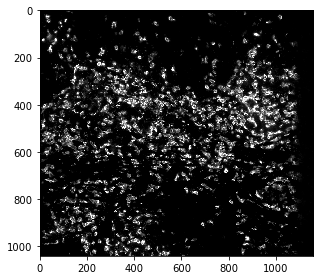

2022-10-10 12:54:15.823942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10429 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:5e:00.0, compute capability: 6.1
/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


(7, 1040, 1159, 1)
(1040, 1159)


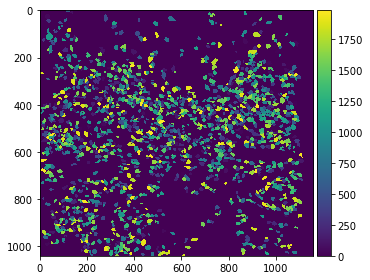

(7, 1040, 1159, 1)


In [2]:
# read image files
imgfiles = glob.glob('images/training/*_img.png')
print(imgfiles)

# show one file
img=io.imread(imgfiles[0])
print(img.shape)
im=img[:,:,0]
io.imshow(im)
plt.show()

imgs = [io.imread(imgfile)[:,:,0] for imgfile in imgfiles]

X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

# read mask files
maskfiles = glob.glob('images/training/*_masks.png')
img=io.imread(maskfiles[0])
print(img.shape)
im=img
io.imshow(im)
plt.show()

masks = [io.imread(imgfile) for imgfile in maskfiles]

y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

np.savez("K_training_data", X=X_train, y=y_train) # objects to save need to be key value pairs

test_size=.2
seed=0
train_dict, test_dict = get_data("K_training_data.npz", test_size=test_size, seed=seed)

In [3]:
# Training model
# One-channel
MODEL_PATH = ('https://deepcell-data.s3-us-west-1.amazonaws.com/'
              'saved-models/NuclearSegmentation-5.tar.gz')
MODEL_HASH = 'c3667ffbe08035c9cb69ed882e4a49d7'
archive_path = tf.keras.utils.get_file(
                'NuclearSegmentation.tgz', MODEL_PATH,
                file_hash=MODEL_HASH,
                extract=True, cache_subdir='models')
model_path = os.path.splitext(archive_path)[0]
print(model_path)


/home/yfong/.keras/models/NuclearSegmentation


In [4]:
new_model = tf.keras.models.load_model(model_path)

import copy
pretrained_model = copy.deepcopy(new_model) # this copy will not be trained

2022-10-10 12:55:25.150291: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://62d825ce-81f4-4006-85a3-2bd357519fd1/assets


/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [5]:
[(layer.output_shape, layer.name) for layer in filter(lambda x: x.name.startswith('semantic_'), new_model.layers)]

[((None, 512, 512, 1), 'semantic_0'), ((None, 512, 512, 1), 'semantic_1')]

In [6]:
transforms = ['inner-distance', 'outer-distance']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}
#                      'inner-distance': {'erosion_width': 1, 'alpha': 'auto'}},

model_name = 'nuclear20221010'
n_epoch = 100
optimizer = Adam(learning_rate=1e-4, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-4, decay=0.99)
batch_size = 1 # 8
min_objects = 0  # throw out images with fewer than this many objects
seed=0
model_name

datagen = image_generators.CroppingDataGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.7, 1/0.7),
    horizontal_flip=True,
    vertical_flip=True,
    #crop_size=(256, 256)) # generate error
    crop_size=(512, 512)) 

datagen_val = image_generators.SemanticDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)
    
train_data = datagen.flow(
    train_dict,
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    test_dict,
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

# Define loss (create a dictionary of losses for each semantic head)

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in new_model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

new_model.compile(loss=loss, optimizer=optimizer)

In [7]:
MODEL_DIR = os.path.join('models')
LOG_DIR = os.path.join('logs')
if not os.path.exists(MODEL_DIR): os.mkdir(MODEL_DIR)
if not os.path.exists(LOG_DIR): os.mkdir(LOG_DIR)    
model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

In [8]:
train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=True,
    #save_weights_only=num_gpus >= 2,
    #monitor='val_loss',
    monitor='loss', # training loss
    verbose=1)

start = default_timer()
loss_history = new_model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    #validation_data=val_data,
    #validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)
training_time = default_timer() - start
print('Training time: ', training_time, 'seconds.')


/tmp/ipykernel_17899/4273487405.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = new_model.fit_generator(


Epoch 1/100


2022-10-10 12:57:02.047218: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


5/5 [==============================] - ETA: 0s - loss: 0.0665 - semantic_0_loss: 0.0243 - semantic_1_loss: 0.0422
Epoch 00001: loss improved from inf to 0.06649, saving model to models/nuclear20221010.h5
5/5 [==============================] - 34s 3s/step - loss: 0.0665 - semantic_0_loss: 0.0243 - semantic_1_loss: 0.0422 - lr: 1.0000e-04
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.0863 - semantic_0_loss: 0.0299 - semantic_1_loss: 0.0564
Epoch 00002: loss did not improve from 0.06649
5/5 [==============================] - 11s 2s/step - loss: 0.0863 - semantic_0_loss: 0.0299 - semantic_1_loss: 0.0564 - lr: 9.9000e-05
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.0805 - semantic_0_loss: 0.0284 - semantic_1_loss: 0.0522
Epoch 00003: loss did not improve from 0.06649
5/5 [==============================] - 11s 2s/step - loss: 0.0805 - semantic_0_loss: 0.0284 - semantic_1_loss: 0.0522 - lr: 9.8010e-05
Epoch 4/100
5/5 [============================

Epoch 27/100
5/5 [==============================] - ETA: 0s - loss: 0.0799 - semantic_0_loss: 0.0272 - semantic_1_loss: 0.0527
Epoch 00027: loss did not improve from 0.05241
5/5 [==============================] - 11s 2s/step - loss: 0.0799 - semantic_0_loss: 0.0272 - semantic_1_loss: 0.0527 - lr: 7.7004e-05
Epoch 28/100
5/5 [==============================] - ETA: 0s - loss: 0.0664 - semantic_0_loss: 0.0236 - semantic_1_loss: 0.0428
Epoch 00028: loss did not improve from 0.05241
5/5 [==============================] - 11s 2s/step - loss: 0.0664 - semantic_0_loss: 0.0236 - semantic_1_loss: 0.0428 - lr: 7.6234e-05
Epoch 29/100
5/5 [==============================] - ETA: 0s - loss: 0.0659 - semantic_0_loss: 0.0230 - semantic_1_loss: 0.0428
Epoch 00029: loss did not improve from 0.05241
5/5 [==============================] - 11s 2s/step - loss: 0.0659 - semantic_0_loss: 0.0230 - semantic_1_loss: 0.0428 - lr: 7.5472e-05
Epoch 30/100
5/5 [==============================] - ETA: 0s - loss: 0.057

Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 0.0614 - semantic_0_loss: 0.0220 - semantic_1_loss: 0.0394
Epoch 00054: loss did not improve from 0.05241
5/5 [==============================] - 11s 2s/step - loss: 0.0614 - semantic_0_loss: 0.0220 - semantic_1_loss: 0.0394 - lr: 5.8704e-05
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0711 - semantic_0_loss: 0.0252 - semantic_1_loss: 0.0458
Epoch 00055: loss did not improve from 0.05241
5/5 [==============================] - 11s 2s/step - loss: 0.0711 - semantic_0_loss: 0.0252 - semantic_1_loss: 0.0458 - lr: 5.8117e-05
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 0.0715 - semantic_0_loss: 0.0257 - semantic_1_loss: 0.0458
Epoch 00056: loss did not improve from 0.05241
5/5 [==============================] - 10s 2s/step - loss: 0.0715 - semantic_0_loss: 0.0257 - semantic_1_loss: 0.0458 - lr: 5.7535e-05
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.063

5/5 [==============================] - ETA: 0s - loss: 0.0827 - semantic_0_loss: 0.0283 - semantic_1_loss: 0.0544
Epoch 00080: loss did not improve from 0.05078
5/5 [==============================] - 11s 2s/step - loss: 0.0827 - semantic_0_loss: 0.0283 - semantic_1_loss: 0.0544 - lr: 4.5204e-05
Epoch 81/100
5/5 [==============================] - ETA: 0s - loss: 0.0837 - semantic_0_loss: 0.0306 - semantic_1_loss: 0.0531
Epoch 00081: loss did not improve from 0.05078
5/5 [==============================] - 11s 2s/step - loss: 0.0837 - semantic_0_loss: 0.0306 - semantic_1_loss: 0.0531 - lr: 4.4752e-05
Epoch 82/100
5/5 [==============================] - ETA: 0s - loss: 0.0568 - semantic_0_loss: 0.0207 - semantic_1_loss: 0.0361
Epoch 00082: loss did not improve from 0.05078
5/5 [==============================] - 11s 2s/step - loss: 0.0568 - semantic_0_loss: 0.0207 - semantic_1_loss: 0.0361 - lr: 4.4305e-05
Epoch 83/100
5/5 [==============================] - ETA: 0s - loss: 0.0769 - semantic_

(256, 256, 3)


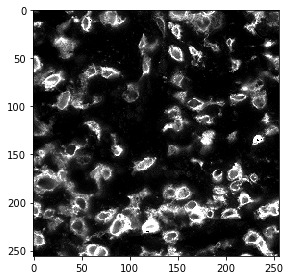

(256, 256)


/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


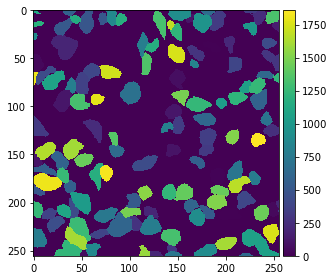

(1, 256, 256, 1)


(1, 393, 393, 1)

In [9]:
img=io.imread("images/square_patches/M872956_JML_Position8_CD3_img_patch256x256.png")
print(img.shape)
im=img[:,:,2]
io.imshow(im)
plt.show()
im=np.expand_dims(im, -1) 
im=np.expand_dims(im, 0) 

mask_true=io.imread("images/square_patches/M872956_JML_Position8_CD3_masks_patch256x256.png")
print(mask_true.shape)
io.imshow(mask_true)
plt.show()

# adjust with image_mpp, not working yet

from deepcell_toolbox.utils import resize

image_mpp=1
shape = im.shape
scale_factor = image_mpp / 0.65
new_shape = (int(shape[1] * scale_factor),
             int(shape[2] * scale_factor))
im2 = resize(im, new_shape, data_format='channels_last')
print(im.shape)
im2.shape # shape changes

In [11]:
# an alternative to application prediction function
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell.model_zoo.panopticnet import PanopticNet

# predict 
prediction_model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 1),
    norm_method=None,
    num_semantic_heads=2,
    #num_semantic_classes=[1, 3], # inner distance, pixelwise; makes error
    num_semantic_classes=[1, 1], # seems to inner distance and outdistance (not pixelwise)
    location=True,  # should always be true
    include_top=True)
prediction_model.load_weights("models/nuclear20221010.h5", by_name=True) # load updated weights

/app/software/DeepCell/0.11.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0.Please use `footprint` instead.
  markers = h_maxima(image=maxima,


0.01775147928994083


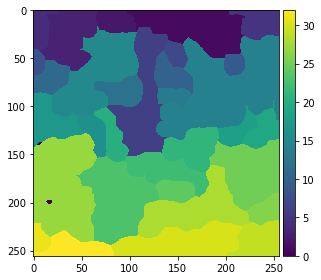

In [12]:
test_images = prediction_model.predict(im)
masks = deep_watershed( # taken from the cytoplasm_segmentation.py
    test_images,
    radius=10, # same as min_distance
    maxima_threshold=0.1, # same as detection_threshold
    interior_threshold=0.01, # same as distance_threshold
    exclude_border=False,
    small_objects_threshold=0)
np.unique(masks[0])
masks[0].shape
io.imshow(masks[0,:,:,0])
#plt.show()
print(syotil.csi(mask_true, masks[0,:,:,0])) # 

0.21893491124260356


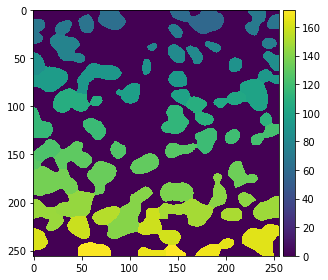

In [13]:
# predict using NuclearSegmentation constructed with pretrained model
# same as app = NuclearSegmentation() because the model is the default one
app = NuclearSegmentation(pretrained_model) 
x=im
y, tile_info = app._tile_input(x)
#print(x.shape)
#print(y.shape)
#print(tile_info)
pred = app.predict(y)#, image_mpp=1) 
prd = app._untile_output(pred, tile_info)
io.imshow(prd[0,:,:,0])
#plt.show()
print(syotil.csi(mask_true, prd[0,:,:,0])) 

0.0


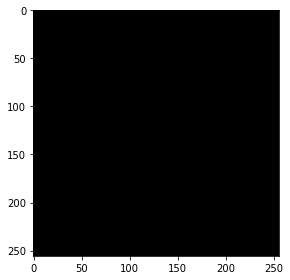

In [14]:
# predict using newly trained model
app = NuclearSegmentation(new_model)
x=im
y, tile_info = app._tile_input(x)
#print(x.shape)
#print(y.shape)
#print(tile_info)
pred = app.predict(y, image_mpp=1) 
prd = app._untile_output(pred, tile_info)
io.imshow(prd[0,:,:,0])
#plt.show()
print(syotil.csi(mask_true, prd[0,:,:,0])) #0

In [ ]:
# read test files
im0 = io.imread('images/test/M872956_JML_Position8_CD3_test_img.png')
print(im0.shape)
im=im0
io.imshow(im)
plt.show()
im = np.expand_dims(im, axis=-1)
im = np.expand_dims(im, axis=0)

mask_true=io.imread("images/test/M872956_JML_Position8_CD3_test_masks.png")
print(mask_true.shape)
io.imshow(mask_true)
plt.show()

In [ ]:
# predict using newly trained model
app = NuclearSegmentation(new_model)
x=im
y, tile_info = app._tile_input(x)
#print(x.shape)
#print(y.shape)
#print(tile_info)
pred = app.predict(y, image_mpp=1) 
prd = app._untile_output(pred, tile_info)
io.imshow(prd[0,:,:,0])
#plt.show()
print(syotil.csi(mask_true, prd[0,:,:,0])) # 0.21 without passing image_mpp. Setting image_mpp to 1 improves to 0.37

In [ ]:
# predict using NuclearSegmentation constructed with pretrained model
# same as app = NuclearSegmentation() because the model is the default one
app = NuclearSegmentation(pretrained_model) 
x=im
y, tile_info = app._tile_input(x)
#print(x.shape)
#print(y.shape)
#print(tile_info)
pred = app.predict(y, image_mpp=1) 
prd = app._untile_output(pred, tile_info)
io.imshow(prd[0,:,:,0])
#plt.show()
print(syotil.csi(mask_true, prd[0,:,:,0])) # 0.21 without passing image_mpp. Setting image_mpp to 1 improves to 0.37